# Generate EMDB-IDs list

In [1]:
from ftplib import FTP

servername = "files.rcsb.org"
ftp = FTP(servername)
ftp.login(user='random_user',passwd='random_password')

subdir = "pub/emdb/structures"

try:
    entries_raw = ftp.nlst(subdir)

except ftplib.error_perm as resp:
    if str(resp) == "550 No files found":
        print("No files in this directory")
    else:
        raise

In [2]:
entries_cleaned = [x.split('/')[-1] for x in entries_raw if '.' not in x.split('/')[-1]]
emdb_entries = entries_cleaned

In [3]:
len(emdb_entries)

24675

# Get experimental annotations

In [4]:
import os
import numpy as np
import requests
import coloredlogs, logging
from time import process_time

In [5]:
# Configure logger
workdir = '/data/dragon000/sanjuan/oxford/cryodb' #os.path.dirname(trajectory_filepath)

coloredlogs.install(level='ERROR')
logging.basicConfig(level=logging.ERROR)
logging.basicConfig(filename=os.path.join(workdir,'emdb_annotations.log'),
                    filemode='w', 
                    format='%(name)s - %(levelname)s - %(message)s')

In [6]:
extract_data = lambda x:x['structure_determination_list']['structure_determination'][0]['specimen_preparation_list']['specimen_preparation'][0]

def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/experiment/'):
    emdb_url = url_prefix + emdb_id
    respond = requests.get(url=emdb_url)
    
    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    
    else:
        data = respond.json()
    
    try:
        exptl_annotations = extract_data(data)
        return exptl_annotations
    
    except Exception as e:

        logger.error(e)
        return None

Iterate over index interval chunks

In [42]:
from operator import itemgetter

N = len(emdb_entries)
d = 100

index_intervals = [range(i*d,(i+1)*d) if (i+1)*d < N else range(i*d,N) for i in range(round(N/d))]

exptl_annotations = {}
for i in range(5):
    entries_interval = itemgetter(*index_intervals[i])(emdb_entries)
    try:
        annotations = {emdb_id:retrieveInfoEMDB(emdb_id) for emdb_id in entries_interval}
        exptl_annotations.update(annotations)
        
    except Exception as e:
        print(e)

In [71]:
exptl_annotations

{'EMD-0001': {'preparation_id': 1,
  'concentration': {'units': 'mg/mL', 'valueOf_': '0.5'},
  'buffer': {'ph': 8.0,
   'component': [{'concentration': {'units': 'mM', 'valueOf_': '10.0'},
     'formula': 'Tris-HCL',
     'name': 'Tris hydrochloride',
     'instance_type': 'component'},
    {'concentration': {'units': 'mM', 'valueOf_': '150.0'},
     'formula': 'NaCL',
     'name': 'sodium chloride',
     'instance_type': 'component'},
    {'concentration': {'units': 'mM', 'valueOf_': '10.0'},
     'formula': 'MgCl2',
     'name': 'magnesium chloride',
     'instance_type': 'component'}]},
  'grid': {'model': 'Quantifoil R1.2/1.3', 'material': 'COPPER'},
  'vitrification': {'cryogen_name': 'ETHANE',
   'chamber_humidity': {'units': 'percentage', 'valueOf_': '95'},
   'chamber_temperature': {'units': 'K', 'valueOf_': '277'},
   'instrument': 'FEI VITROBOT MARK IV'},
  'instance_type': 'single_particle_preparation'},
 'EMD-0002': {'preparation_id': 1,
  'concentration': {'units': 'mg/mL'

Save data

In [14]:
import pickle
with open('test_data.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

<span style='color:red'><b>ISSUE</b></span>
* Connection dies after certain number of requests (>300 entries)

```python
ConnectionError: HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-0348 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f9218e429d0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
```

# Pipeline Routine: Proof of concept

Gather list of EMDB entries

In [1]:
import pickle
import numpy as np
from ftplib import FTP
from operator import itemgetter

import os
import numpy as np
import requests
import coloredlogs, logging
from time import process_time


def get_emdb_entries():
    servername = "files.rcsb.org"
    ftp = FTP(servername)
    ftp.login(user='random_user',passwd='random_password')

    subdir = "pub/emdb/structures"

    try:
        entries_raw = ftp.nlst(subdir)

    except ftplib.error_perm as resp:
        if str(resp) == "550 No files found":
            print("No files in this directory")
        else:
            raise

    entries_cleaned = [x.split('/')[-1] for x in entries_raw if '.' not in x.split('/')[-1]]
    emdb_entries = entries_cleaned
    
    return emdb_entries


def retrieveInfoEMDB(emdb_id, url_prefix='https://www.ebi.ac.uk/emdb/api/entry/experiment/'):
    extract_data = lambda x:x['structure_determination_list']['structure_determination'][0]['specimen_preparation_list']['specimen_preparation'][0]
    emdb_url = url_prefix + emdb_id
    respond = requests.get(url=emdb_url)
    
    if respond.status_code != 200:
        logging.error("request status %d" % (respond.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (respond.status_code))
    
    else:
        data = respond.json()
    
    try:
        exptl_annotations = extract_data(data)
        return exptl_annotations
    
    except Exception as e:

        logger.error(e)
        return None


def partition_range(N, num_partitions):
    partition_size = N // num_partitions
    partitions = [range(i * partition_size, (i + 1) * partition_size) for i in range(num_partitions - 1)]
    partitions.append(range((num_partitions - 1) * partition_size, N))
    
    return partitions

def get_exptl_annotations(emdb_entries, interval_length=100):
    N_entries = len(emdb_entries)
    num_partitions = int(N_entries/interval_length)
    index_intervals = partition_range(N_entries, num_partitions)

    exptl_annotations = {}
    for i in range(len(index_intervals)):
        entries_interval = itemgetter(*index_intervals[i])(emdb_entries)
        try:
            annotations = {emdb_id:retrieveInfoEMDB(emdb_id) for emdb_id in entries_interval}
            exptl_annotations.update(annotations)

        except Exception as e:
            print(e)
    
    return exptl_annotations

In [3]:
emdb_entries = get_emdb_entries()

In [4]:
exptl_annotations = get_exptl_annotations(emdb_entries)

HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-0201 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b9267880>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-0207 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b9267640>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-11480 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b9824880>: Failed to establish a new connection: [Errno 110] Connection timed out'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-11994 (Cause

HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-30724 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b95c71f0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-30855 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b9824880>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-3100 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b952d400>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-31149 (

HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-8815 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b96bb970>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-8934 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b95c7100>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-9040 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b96bb1c0>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-9143 (Cau

HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-15954 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b983e370>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-15314 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b952de80>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-28705 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f38b96bb970>: Failed to establish a new connection: [Errno -2] Name or service not known'))
HTTPSConnectionPool(host='www.ebi.ac.uk', port=443): Max retries exceeded with url: /emdb/api/entry/experiment/EMD-14377 

In [7]:
len(exptl_annotations.keys())

4300

In [6]:
import pickle
with open('data/exptl_annotations_test_30-Jan-2023.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

In [8]:
!cp data/exptl_annotations_test_30-Jan-2023.pickle test_data.pickle

Save data

In [26]:
import pickle

with open('test_data_600-entries.pickle', 'wb') as fp:
    pickle.dump(exptl_annotations, fp)

Estimate output filesize and gathering time

In [36]:
filesize = 289 # KB
N_entries_test = 600
all_expected_filesize = filesize*N_entries/(N_entries_test*1000) # MB
print(all_expected_filesize, 'MB')

11.885125 MB


In [37]:
filetime = 1.5 # mins
N_entries_test = 600
all_expected_filetime = filetime*N_entries/(N_entries_test) # mins
print(all_expected_filetime, 'minutes')

61.6875 minutes


# Evaluate scope of data availabilty

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
import pickle
with open('test_data.pickle', 'rb') as fp:
    exptl_annotations = pickle.load(fp)

In [10]:
len(exptl_annotations.keys())

4300

## Annotation Universe

In [11]:
annotations_universe = set()
for emdb_id in exptl_annotations.keys():
    annotations = set(exptl_annotations[emdb_id].keys())
    annotations_universe = annotations_universe.union(annotations)

In [12]:
annotations_universe

{'buffer',
 'concentration',
 'cryo_protectant',
 'crystal_formation',
 'details',
 'fiducial_markers_list',
 'grid',
 'high_pressure_freezing',
 'instance_type',
 'preparation_id',
 'sectioning',
 'staining',
 'sugar_embedding',
 'vitrification'}

In [13]:
len(annotations_universe)

14

## Number of annotations

In [14]:
n_annotations = {key: len(exptl_annotations[key].keys()) for key in exptl_annotations.keys()}

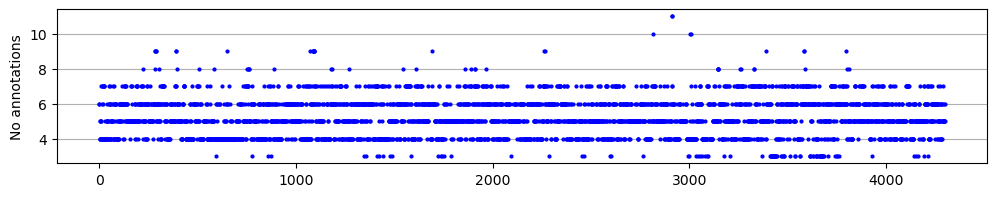

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,2),dpi=100)

ax.plot(n_annotations.values(),'bo',markersize=2)
ax.set_ylabel('No annotations')
ax.yaxis.grid(True)

plt.show()

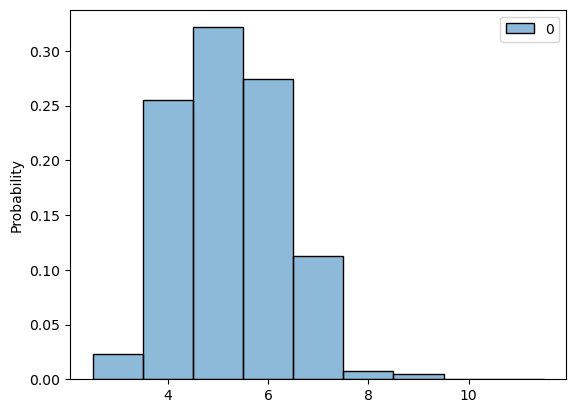

In [18]:
hist = sns.histplot(n_annotations.values(),
                    stat='probability',
                    discrete=True)


## Sample entries

Maximum number of annotations

In [19]:
for emdb_id in n_annotations.keys():
    if len(exptl_annotations[emdb_id].keys()) == 8:
        print(emdb_id)

EMD-0444
EMD-0507
EMD-0530
EMD-0619
EMD-0733
EMD-0809
EMD-0987
EMD-0994
EMD-0995
EMD-0996
EMD-10113
EMD-10385
EMD-10386
EMD-10466
EMD-10720
EMD-1079
EMD-11025
EMD-11057
EMD-11073
EMD-11074
EMD-11124
EMD-12726
EMD-12727
EMD-12728
EMD-12729
EMD-12917
EMD-12940
EMD-13085
EMD-13086
EMD-1756
EMD-20068
EMD-20082


In [20]:
exptl_annotations['EMD-0162']

KeyError: 'EMD-0162'

Minumum number of annotations

In [21]:
for emdb_id in n_annotations.keys():
    if len(exptl_annotations[emdb_id].keys()) == 4:
        print(emdb_id)

EMD-0004
EMD-0005
EMD-0006
EMD-0009
EMD-0011
EMD-0015
EMD-0016
EMD-0017
EMD-0018
EMD-0022
EMD-0026
EMD-0027
EMD-0028
EMD-0029
EMD-0030
EMD-0032
EMD-0033
EMD-0034
EMD-0035
EMD-0036
EMD-0037
EMD-0044
EMD-0045
EMD-0047
EMD-0048
EMD-0049
EMD-0055
EMD-0063
EMD-0064
EMD-0065
EMD-0076
EMD-0080
EMD-0081
EMD-0082
EMD-0083
EMD-0090
EMD-0091
EMD-0092
EMD-0096
EMD-0097
EMD-0098
EMD-0099
EMD-0100
EMD-0101
EMD-0102
EMD-0104
EMD-0105
EMD-0334
EMD-0338
EMD-0368
EMD-0397
EMD-0403
EMD-0411
EMD-0441
EMD-0453
EMD-0454
EMD-0464
EMD-0465
EMD-0467
EMD-0497
EMD-0524
EMD-0534
EMD-0536
EMD-0537
EMD-0538
EMD-0558
EMD-0569
EMD-0570
EMD-0571
EMD-0572
EMD-0573
EMD-0574
EMD-0575
EMD-0576
EMD-0577
EMD-0578
EMD-0579
EMD-0580
EMD-0581
EMD-0582
EMD-0641
EMD-0644
EMD-0645
EMD-0646
EMD-0647
EMD-0648
EMD-0667
EMD-0668
EMD-0669
EMD-0670
EMD-0671
EMD-0674
EMD-0675
EMD-0676
EMD-0677
EMD-0678
EMD-0679
EMD-0680
EMD-0681
EMD-0682
EMD-0683
EMD-0684
EMD-0685
EMD-0688
EMD-0693
EMD-0694
EMD-0695
EMD-0696
EMD-0697
EMD-0698
EMD-0699
E

In [74]:
exptl_annotations['EMD-0004']

{'preparation_id': 1,
 'buffer': {'ph': 7.4},
 'vitrification': {'cryogen_name': 'ETHANE'},
 'instance_type': 'single_particle_preparation'}

## Annotation categories

Determine category indentities

In [22]:
annotations_subsets = []
for emdb_id in exptl_annotations.keys():
    annotations = list(exptl_annotations[emdb_id].keys())
    annotations_subsets.append(annotations)

In [23]:
import itertools
annotations_subsets.sort()

annotations_categories = list(k for k,_ in itertools.groupby(annotations_subsets))

In [24]:
annotations_categories

[['preparation_id',
  'buffer',
  'details',
  'high_pressure_freezing',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'fiducial_markers_list',
  'cryo_protectant',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'fiducial_markers_list',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'details',
  'sectioning',
  'instance_type'],
 ['preparation_id',
  'buffer',
  'grid',
  'vitrification',
  'fiducial_markers_list',
  'cryo_protectant',
  'sectioning

In [25]:
len(annotations_categories)

68

Determine the entries split into these categories

In [94]:
import json

In [100]:
entries_by_category = {}
for category in annotations_categories:
    category_key = json.dumps(category)
    entries_by_category[category_key] = []
    for emdb_id in exptl_annotations.keys():
        annotations = set(exptl_annotations[emdb_id].keys())
        if annotations == set(category):
            entries_by_category[category_key].append(emdb_id)

In [101]:
entries_by_category

{'["preparation_id", "buffer", "grid", "vitrification", "details", "instance_type"]': ['EMD-0205',
  'EMD-0207',
  'EMD-0290',
  'EMD-0292',
  'EMD-0293',
  'EMD-0325'],
 '["preparation_id", "buffer", "grid", "vitrification", "instance_type"]': ['EMD-0031',
  'EMD-0043',
  'EMD-0061',
  'EMD-0062',
  'EMD-0070',
  'EMD-0107',
  'EMD-0137',
  'EMD-0138',
  'EMD-0139',
  'EMD-0149',
  'EMD-0150',
  'EMD-0164',
  'EMD-0165',
  'EMD-0167',
  'EMD-0168',
  'EMD-0169',
  'EMD-0170',
  'EMD-0175',
  'EMD-0198',
  'EMD-0262',
  'EMD-0263',
  'EMD-0274',
  'EMD-0348',
  'EMD-0349',
  'EMD-0350',
  'EMD-0359',
  'EMD-0360',
  'EMD-0361',
  'EMD-0363',
  'EMD-0364',
  'EMD-0365',
  'EMD-0366',
  'EMD-0369',
  'EMD-0370',
  'EMD-0371',
  'EMD-0373',
  'EMD-0374',
  'EMD-0379',
  'EMD-0380',
  'EMD-0381',
  'EMD-0383',
  'EMD-0386',
  'EMD-0387',
  'EMD-0388',
  'EMD-0390'],
 '["preparation_id", "buffer", "staining", "grid", "details", "instance_type"]': ['EMD-0324'],
 '["preparation_id", "buffer",

In [110]:
for key in entries_by_category.keys():
    print(len(entries_by_category[key]), key, len(json.loads(key)))

6 ["preparation_id", "buffer", "grid", "vitrification", "details", "instance_type"] 6
45 ["preparation_id", "buffer", "grid", "vitrification", "instance_type"] 5
1 ["preparation_id", "buffer", "staining", "grid", "details", "instance_type"] 6
1 ["preparation_id", "buffer", "staining", "grid", "instance_type"] 5
1 ["preparation_id", "buffer", "vitrification", "details", "fiducial_markers_list", "sectioning", "instance_type"] 7
2 ["preparation_id", "buffer", "vitrification", "details", "instance_type"] 5
2 ["preparation_id", "buffer", "vitrification", "fiducial_markers_list", "sectioning", "instance_type"] 6
94 ["preparation_id", "buffer", "vitrification", "instance_type"] 4
29 ["preparation_id", "concentration", "buffer", "grid", "vitrification", "details", "instance_type"] 7
53 ["preparation_id", "concentration", "buffer", "grid", "vitrification", "instance_type"] 6
2 ["preparation_id", "concentration", "buffer", "vitrification", "details", "fiducial_markers_list", "sectioning", "insta

### Subcategories

Full annotations

In [116]:
exptl_annotations['EMD-0162']

{'preparation_id': 1,
 'concentration': {'units': 'mg/mL', 'valueOf_': '1.1'},
 'buffer': {'ph': 7.5,
  'component': [{'concentration': {'units': 'mM', 'valueOf_': '20.0'},
    'formula': 'C8H19KN2O5S',
    'name': 'HEPES-KOH',
    'instance_type': 'component'},
   {'concentration': {'units': 'mM', 'valueOf_': '200.0'},
    'formula': 'NaCl',
    'name': 'sodium chloride',
    'instance_type': 'component'}]},
 'vitrification': {'cryogen_name': 'ETHANE',
  'chamber_humidity': {'units': 'percentage', 'valueOf_': '95'},
  'chamber_temperature': {'units': 'K', 'valueOf_': '292'},
  'instrument': 'LEICA EM GP'},
 'details': 'The solution-assembled complex was incubated with Folch liposomes at room temperature.',
 'fiducial_markers_list': {'fiducial_marker': [{'manufacturer': 'BBI solutions',
    'diameter': {'units': 'nanometer', 'valueOf_': '10'},
    'instance_type': 'fiducial_marker'}]},
 'sectioning': {'other_sectioning': 'NO SECTIONING'},
 'instance_type': 'tomography_preparation'}

In [115]:
exptl_annotations['EMD-0162']['buffer']['component']

[{'concentration': {'units': 'mM', 'valueOf_': '20.0'},
  'formula': 'C8H19KN2O5S',
  'name': 'HEPES-KOH',
  'instance_type': 'component'},
 {'concentration': {'units': 'mM', 'valueOf_': '200.0'},
  'formula': 'NaCl',
  'name': 'sodium chloride',
  'instance_type': 'component'}]

In [117]:
import pydot

menu = {'dinner':
            {'chicken':'good',
             'beef':'average',
             'vegetarian':{
                   'tofu':'good',
                   'salad':{
                            'caeser':'bad',
                            'italian':'average'}
                   },
             'pork':'bad'}
        }

def draw(parent_name, child_name):
    edge = pydot.Edge(parent_name, child_name)
    graph.add_edge(edge)
    
def visit(node, parent=None):
    for k,v in node.iteritems():# If using python3, use node.items() instead of node.iteritems()
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            draw(k, k+'_'+v)

graph = pydot.Dot(graph_type='graph')
visit(menu)

ModuleNotFoundError: No module named 'pydot'

**NOTE**

* Finding out the different types of annotation categories and subcategories is complex, because annotations follow a hierarchy, and different subcategories may have more than one instance

* This may require a tree-like graph to properly display their distribution from the whole annotation dataset
* Some ideas for visualisation, (i) https://stackoverflow.com/questions/13688410/dictionary-object-to-decision-tree-in-pydot and (ii) https://itsvit.com/blog/big-data-information-visualization-techniques/ 
* Check Newick form format for tree graphs! https://en.wikipedia.org/wiki/Newick_format

# Code Snippets

<span style='color:red'>NEXT</span>
* Find a way to filter only experimental data per ID, test with 10 entries. 
* THEN, estimate how long and how much memory it will take get these data.

In [ ]:
@retry_decorator
def retrieveInfoFromEMDB(emdb_id):
    resp = requests.get(url=EMDB_INFO_QUERY % emdbId)
    
    if resp.status_code != 200:
        logger.error("request status %d" % (resp.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (resp.status_code))
    else:
        data = resp.json()[emdbId][0]
        try:
            pdbs = data["deposition"]["fitted_pdb_id_list"]
            pdbs = [elem.lower() for elem in pdbs["pdb_id"]]
        except KeyError:
            try:
                pdbs = [elem["pdb_id_list"]["pdb_id"][0].lower() for elem in data["experiment"]["fitting"]]
            except KeyError:
                logger.error("%s has not associated pdb" % (emdbId))
                raise DownloadException("Error, %s has not associated pdb" % (emdbId))

        voxel_size = data["map"]["pixel_spacing"]["y"]["value"]
        max_val_vox = data["map"]["statistics"]["maximum"]
        grid_shape = [int(elem) for elem in data["map"]["dimensions"].values()]

        axis_order = data["map"]["axis_order"]
        axis_order = [axis_order["slow"], axis_order["medium"], axis_order["fast"]]
        coords_origin = data["map"]["origin"]
        coords_origin = [coords_origin["section"], coords_origin["row"],
                         coords_origin["column"]]  # order slow, medium, fast
        try:
            resolution = float(data["processing"]["reconstruction"]["resolution_by_author"])
        except KeyError:
            raise DownloadException("Error, no resolution available for %s " % (emdbId))

        date = data["deposition"]["deposition_date"]
        info = {"voxel_size": voxel_size, "max_val_vox": max_val_vox, "grid_shape": grid_shape,
                "coords_origin": coords_origin,
                "resolution": resolution, "pdbs": pdbs, "axis_order": axis_order, "date": date}
        if resolution > config.WORSE_RESOLUTION_ALLOWED:
            msg = "Error downloading %s. Too bad resolution:\n" % (emdbId,)
            logger.error(msg)
            raise DownloadException(msg)
            # writeErrorFile(emdbId, "Error downloading %s. Too bad resolution:\n" % (emdbId,), info, pdbId="")

        if len(set(grid_shape)) > 1:
            logger.error(f"Error downloading {emdbId}: Just cubic volumes are considered")
            raise DownloadException("Error downloading %s. Just cubic volumes are considered:\n" % (emdbId,))
        return info

In [48]:
myurl = prefix+emdb_entries[0]

In [49]:
resp = requests.get(url=myurl)
data = resp.json()

In [53]:
data

{'emdb_id': 'EMD-0001',
 'structure_determination_list': {'structure_determination': [{'structure_determination_id': 1,
    'method': 'singleParticle',
    'aggregation_state': 'particle',
    'specimen_preparation_list': {'specimen_preparation': [{'preparation_id': 1,
       'concentration': {'units': 'mg/mL', 'valueOf_': '0.5'},
       'buffer': {'ph': 8.0,
        'component': [{'concentration': {'units': 'mM', 'valueOf_': '10.0'},
          'formula': 'Tris-HCL',
          'name': 'Tris hydrochloride',
          'instance_type': 'component'},
         {'concentration': {'units': 'mM', 'valueOf_': '150.0'},
          'formula': 'NaCL',
          'name': 'sodium chloride',
          'instance_type': 'component'},
         {'concentration': {'units': 'mM', 'valueOf_': '10.0'},
          'formula': 'MgCl2',
          'name': 'magnesium chloride',
          'instance_type': 'component'}]},
       'grid': {'model': 'Quantifoil R1.2/1.3', 'material': 'COPPER'},
       'vitrification': {'c

In [50]:
data['structure_determination_list']['structure_determination'][0].keys()

dict_keys(['structure_determination_id', 'method', 'aggregation_state', 'specimen_preparation_list', 'microscopy_list', 'image_processing', 'instance_type'])

**NOTE** 

This doesn't work with EMDB! It produces no output.

```python
url = 'https://www.ebi.ac.uk/emdb/api/annotations/'
reqs = requests.get(url)
soup = BeautifulSoup(reqs.text, 'html.parser')
 
urls = []
for link in soup.find_all('a'):
    print(link.get('href'))
```    

**NOTES**

To gather all the data I need to compile a list of the currently available non-obsolete entries in EMDB
* Option 1: Take a for loop running serially up to a high number. IDs take a 4-digit numeric format only and seem to run serially, except for a few which I suspect are obsolete. 
* Option 2: Compile a list from here https://files.rcsb.org/pub/emdb/structures/ . Try `ftplib`?

Ruben's functions. Taking bits and pieces, but mostly ideas.

In [ ]:
@retry_decorator
def retrieveInfoFromEMDB(emdbId):
    resp = requests.get(url=EMDB_INFO_QUERY % emdbId)
    if resp.status_code != 200:
        logger.error("request status %d" % (resp.status_code))
        raise DownloadException("Error, retrieveInfoFromEMDB request status %d" % (resp.status_code))
    else:
        data = resp.json()[emdbId][0]
        try:
            pdbs = data["deposition"]["fitted_pdb_id_list"]
            pdbs = [elem.lower() for elem in pdbs["pdb_id"]]
        except KeyError:
            try:
                pdbs = [elem["pdb_id_list"]["pdb_id"][0].lower() for elem in data["experiment"]["fitting"]]
            except KeyError:
                logger.error("%s has not associated pdb" % (emdbId))
                raise DownloadException("Error, %s has not associated pdb" % (emdbId))

        voxel_size = data["map"]["pixel_spacing"]["y"]["value"]
        max_val_vox = data["map"]["statistics"]["maximum"]
        grid_shape = [int(elem) for elem in data["map"]["dimensions"].values()]

        axis_order = data["map"]["axis_order"]
        axis_order = [axis_order["slow"], axis_order["medium"], axis_order["fast"]]
        coords_origin = data["map"]["origin"]
        coords_origin = [coords_origin["section"], coords_origin["row"],
                         coords_origin["column"]]  # order slow, medium, fast
        try:
            resolution = float(data["processing"]["reconstruction"]["resolution_by_author"])
        except KeyError:
            raise DownloadException("Error, no resolution available for %s " % (emdbId))

        date = data["deposition"]["deposition_date"]
        info = {"voxel_size": voxel_size, "max_val_vox": max_val_vox, "grid_shape": grid_shape,
                "coords_origin": coords_origin,
                "resolution": resolution, "pdbs": pdbs, "axis_order": axis_order, "date": date}
        if resolution > config.WORSE_RESOLUTION_ALLOWED:
            msg = "Error downloading %s. Too bad resolution:\n" % (emdbId,)
            logger.error(msg)
            raise DownloadException(msg)
            # writeErrorFile(emdbId, "Error downloading %s. Too bad resolution:\n" % (emdbId,), info, pdbId="")

        if len(set(grid_shape)) > 1:
            logger.error(f"Error downloading {emdbId}: Just cubic volumes are considered")
            raise DownloadException("Error downloading %s. Just cubic volumes are considered:\n" % (emdbId,))
        return info

In [ ]:
@retry_decorator
def downloadEMDB(emdbId, mapsOutDir):
    outName = os.path.join(mapsOutDir, emdbId + '.map')
    logger.info("Trying to download emdb %s to %s" % (emdbId, outName))
    if not os.path.isfile(outName):
        emd, num = emdbId.split("-")
        cmd = ('wget -qO- ' + EMDB_DONWLOAD_QUERY + ' --timeout=' +str(TIMEOUT_TIME)+
               '  | zcat  > %s') % (emdbId, num, outName + ".tmp")
        logger.info(cmd)
        p = Popen(cmd, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=True, executable="/bin/bash")
        out = p.communicate()
        if len(out[1]) > 0:
            logger.error(out)
            tryToRemove(outName + ".tmp")
            msg = "Error downloading (wget) emdbId %s to %s. %s" % (emdbId, outName, out)
            raise DownloadException(msg)
        os.rename(outName + ".tmp", outName)
    else:
        logger.warn("Already downloaded emdbId %s ->%s " % (emdbId, outName))

    return outName

@retry_decorator
def downloadEMDB_halfMaps(emdbId, mapsOutDir, onlyAverage=False):
    outName = os.path.join(mapsOutDir, emdbId + '.map')
    logger.info("Trying to download emdbID %s to %s" % (emdbId, outName))
    halfFnames = []
    if not os.path.isfile(outName):
        try:
            time.sleep(random.randint(0,TIMEOUT_TIME))
            ftp = ftplib.FTP(EMDB_FTP_SERVER)
            ftp.login()
            try:
                ftp.cwd(EMDB_FTP_DIR % emdbId)
            except ftplib.all_errors as e:
                msg = f"FTTP error for {emdbId}. It probabaly does not contain half-maps: " + str(e)
                logger.error(msg)
                raise DownloadException(msg)
            fnames = ftp.nlst()
            half_names_inServer = [None, None]
            logger.info("Downaloading half maps: "+ " "+" ".join(fnames))
            for fname in fnames:
                match_objs = re.match(".*half[-_\.]*(map_?)*([12])", fname)
                if match_objs:
                    half_names_inServer[int(match_objs.group(2)) - 1] = fname
            logger.info(half_names_inServer)
            if None in half_names_inServer:
                raise DownloadException(f"Error, half map not available for {emdbId}")
            tmp_halfs = []
            tmp_half_name = None
            for halfNum in range(1, 3):
                try:
                    tmp_half_name = outName + "_half_%d.tmp.mrc" % halfNum
                    tmp_halfs.append(tmp_half_name)
                    with  BytesIO() as flo:
                        ftp.retrbinary('RETR ' + half_names_inServer[halfNum - 1], flo.write)
                        flo.seek(0)
                        with open(tmp_half_name, 'wb') as fout, gzip.GzipFile(fileobj=flo) as fgzip:
                            shutil.copyfileobj(fgzip, fout)
                except ftplib.all_errors as e:
                    logger.error(f"FTTP error for {emdbId}: "+str(e))
                    raise e
                    # if tmp_half_name:
                    #     tryToRemove(tmp_half_name)
                    # msg = "Error downloading emdbId %s to %s: %s" % (emdbId, outName, str(e))
                    # raise DownloadException(msg)
        except ftplib.all_errors as e:
            logger.error(f"FTTP error for {emdbId}: " + str(e))
            raise e
            # msg = "Error downloading emdbId %s to %s: %s" % (emdbId, outName, str(e))
            # raise DownloadException(msg)

        data = loadVol(tmp_halfs[0])[0]
        data += loadVol(tmp_halfs[1])[0]
        data /= 2.
        saveVol(outName, data, fname_headerLike=tmp_halfs[0])
        if onlyAverage:
            for tmp_half_name in tmp_halfs:
                tryToRemove(tmp_half_name)
        else:
            for tmp_half_name in tmp_halfs:
                new_fname = tmp_half_name.replace(".tmp", "")
                os.rename(tmp_half_name, new_fname)
                halfFnames.append(new_fname)
    else:
        logger.warn("Already downloaded emdbId %s ->%s " % (emdbId, outName))

    return outName, halfFnames